<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#J1-J2模型" data-toc-modified-id="J1-J2模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>J1-J2模型</a></span></li><li><span><a href="#格点MPO" data-toc-modified-id="格点MPO-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>格点MPO</a></span></li><li><span><a href="#MPS正则表示" data-toc-modified-id="MPS正则表示-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MPS正则表示</a></span><ul class="toc-item"><li><span><a href="#单格点" data-toc-modified-id="单格点-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>单格点</a></span></li><li><span><a href="#J1-J2" data-toc-modified-id="J1-J2-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>J1-J2</a></span></li></ul></li><li><span><a href="#确定边界" data-toc-modified-id="确定边界-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>确定边界</a></span></li><li><span><a href="#能量期望值" data-toc-modified-id="能量期望值-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>能量期望值</a></span></li><li><span><a href="#VUMPS" data-toc-modified-id="VUMPS-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>VUMPS</a></span><ul class="toc-item"><li><span><a href="#单格点" data-toc-modified-id="单格点-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>单格点</a></span></li><li><span><a href="#J1-J2" data-toc-modified-id="J1-J2-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>J1-J2</a></span></li></ul></li><li><span><a href="#程序检验" data-toc-modified-id="程序检验-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>程序检验</a></span><ul class="toc-item"><li><span><a href="#bond强度比例-r" data-toc-modified-id="bond强度比例-r-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>bond强度比例 r</a></span></li><li><span><a href="#温度-β" data-toc-modified-id="温度-β-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>温度 β</a></span></li></ul></li><li><span><a href="#待解决问题" data-toc-modified-id="待解决问题-8"><span class="toc-item-num">8&nbsp;&nbsp;</span><font color="Red">待解决问题</font></a></span><ul class="toc-item"><li><span><a href="#快速迭代得到$L1，L2$时不收敛" data-toc-modified-id="快速迭代得到$L1，L2$时不收敛-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>快速迭代得到$L1，L2$时不收敛</a></span></li><li><span><a href="#r-=-1.01~1.1之间时能量不能极小化" data-toc-modified-id="r-=-1.01~1.1之间时能量不能极小化-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>r = 1.01~1.1之间时能量不能极小化</a></span></li></ul></li></ul></div>

## J1-J2模型 
横向连接耦合强度为$J_1,J_2$交替排布，纵向全为$J_1$
<img src="figure/1.png" width="50%">

## 格点MPO
权重张量为$M1,M2$
<img src="figure/2.png" width="50%">
红色连接上张量为
$\exp(-J_2 h_{ij})$, $J_2 = r J_1$

要收缩的目标张量Z2为
<img src="figure/6.png" width="25%">

能量权重张量为$ME1,ME2$
<img src="figure/3.png" width="50%">

In [1]:
# call library
using LinearAlgebra, TensorOperations, KrylovKit, Random, Statistics

In [2]:
# define M1,M2,ME1,ME1
function statmechmpo(β, h, D; r = 2.0)
    I = zeros(D,D,D,D)
    for i = 1:D
        I[i,i,i,i] = 1
    end
 
    X1 = zeros(D,D)
    for j = 1:D, i = 1:D
        X1[i,j] = exp(-β*h(i,j))
    end

    X2 = zeros(D,D)
    for j = 1:D, i = 1:D
        X2[i,j] = exp(-β*r*h(i,j))
    end

    X1sq = sqrt(X1)
    X2sq = sqrt(X2)

    @tensor M1[a,b,c,d] := I[a',b',c',d']*X2sq[c',c]*X1sq[d',d]*X1sq[a',a]*X1sq[b',b]
    M2 = permutedims(M1,[3,2,1,4])

    # For computing energy: M2 is a tensor across 2 nearest neighbor sites in the lattice, whose
    # expectation value in the converged fixed point of the transfer matrix represents the energy
    Y1 = zeros(D,D)
    for j = 1:D, i = 1:D
        Y1[i,j] = h(i,j)*exp(-β*h(i,j))
    end
    Y2 = zeros(D,D)
    for j = 1:D, i = 1:D
        Y2[i,j] = r*h(i,j)*exp(-β*r*h(i,j))
    end

    @tensor ME1[a,b1,b2,c,d2,d1] := I[a',b1',c1,d1']*X2sq[a,a']*X1sq[b1,b1']*X1sq[d1',d1]* Y1[c1,c2]*
                                    I[c2,b2',c',d2']*X1sq[b2,b2']*X1sq[d2',d2]*X2sq[c',c]
    @tensor ME2[a,b1,b2,c,d2,d1] := I[a',b1',c1,d1']*X1sq[a,a']*X1sq[b1,b1']*X1sq[d1',d1]* Y2[c1,c2]*
                                    I[c2,b2',c',d2']*X1sq[b2,b2']*X1sq[d2',d2]*X1sq[c',c]
    return M1, M2, ME1, ME2
end

classicalisingmpo(β; J = 1.0, h = 0.,r = 1.0) = statmechmpo(β, (s1,s2)->-J*(-1)^(s1!=s2) - h/2*(s1==1 + s2==1),
                                                                                            2;r)

classicalisingmpo (generic function with 1 method)

In [3]:
#test
βc = log(1+sqrt(2))/2
β = 0.95*βc
M1, M2, ME1, ME2 = classicalisingmpo(β; r = 1.0)
@show norm(M1.-M2) norm(ME1.-ME2)

norm(M1 .- M2) = 1.8410966031475738e-16
norm(ME1 .- ME2) = 0.0


0.0

## MPS正则表示
### 单格点
对于Uniform MPS，在归一化时，边界收缩为
<img src="figure/4.png" width="50%">
从而引入左右正则张量$AL$和$AR$：
<img src="figure/5.png" width="30%">
使得边界收缩掉
<img src="figure/7.png" width="30%">
具体做法为在$A$张量间，左边插入$L^{-1}L$，右边边插入$L^{-1}L$，然后根据周期不变性得到红色方框中的相等的变换关系
<img src="figure/8.png" width="50%">

### J1-J2
对于A1-A2 MPS，在归一化时，边界收缩为
<img src="figure/9.png" width="40%">
同样引入左正则表示
<img src="figure/10.png" width="40%">
将Uniform形式变换为正则表示，左边插入$L1^{-1}L1L2^{-1}L2$，右边插入$R1R1^{-1}R2R2^{-1}$
<img src="figure/11.png" width="100%">
不同于Uniform形式，$AL1$和$AL2$间多了$L1L2^{-1}$，$AL1$和$AL2$间多了$R1^{-1}R2$，为了收缩能够继续，必须要求
<img src="figure/12.png" width="50%">

In [4]:
# function to get AL1,AL2 and AR1,AR2
safesign(x::Number) = iszero(x) ? one(x) : sign(x)

"""
    qrpos(A)

Returns a QR decomposition, i.e. an isometric `Q` and upper triangular `R` matrix, where `R`
is guaranteed to have positive diagonal elements.
"""
qrpos(A) = qrpos!(copy(A))
function qrpos!(A)
    F = qr!(A)
    Q = Matrix(F.Q)
    R = F.R
    phases = safesign.(diag(R))
    rmul!(Q, Diagonal(phases))
    lmul!(Diagonal(conj!(phases)), R)
    return Q, R
end

"""
    lqpos(A)

Returns a LQ decomposition, i.e. a lower triangular `L` and isometric `Q` matrix, where `L`
is guaranteed to have positive diagonal elements.
"""
lqpos(A) = lqpos!(copy(A))
function lqpos!(A)
    F = qr!(Matrix(A'))
    Q = Matrix(Matrix(F.Q)')
    L = Matrix(F.R')
    phases = safesign.(diag(L))
    lmul!(Diagonal(phases), Q)
    rmul!(L, Diagonal(conj!(phases)))
    return L, Q
end

function ρmap(ρ,A1,A2)
    @tensor ρ1[a,b] := ρ[a',b']*A1[b',s,b]*conj(A1[a',s,a])
    @tensor ρ2[a,b] := ρ1[a',b']*A2[b',s,b]*conj(A2[a',s,a])
    return ρ2
end
        
"""
    getL(ρ; kwargs...)
    ┌ A1─A2─    ┌       L ─
    ρ │  │    = ρ   =  │
    ┕ A1─A2─    ┕       L'─
ρ=L'*L, return L, where `L`is guaranteed to have positive diagonal elements.
L = cholesky!(ρ).U
If ρ is not exactly positive definite, cholesky will fail
"""
function getL!(L,A1,A2)
    λs,ρs,_ = eigsolve(ρ->ρmap(ρ,A1,A2),L'*L, 1, :LM; ishermitian = false, tol = 1e-12, maxiter = 1)
#     ρ2 = ρmap(ρs[1],A1,A2)
#     @show norm(ρ2.-ρs[1]*λs[1])
    ρ = ρs[1] + ρs[1]'
    ρ ./= tr(ρ)
    F = svd!(ρ)
    L = lmul!(Diagonal(sqrt.(F.S)), F.Vt)
    _, L = qrpos!(L)
    return L
end

"""
    getAL(A)

Given an MPS tensor `A` and `L` ，return a left-canonical MPS tensor `AL`, a gauge transform `R` and
a scalar factor `λ` such that ``λ AR R = L A``
"""
function getAL(A,L1,L2)
    D, d, = size(A) 
    Q, R = qrpos!(reshape(L1*reshape(A, D, d*D), D*d, D))
    AL = reshape(Q, D, d, D)
    @tensor AL[a,s,b] := AL[a,s,d1] * L2[d1,d2] * (L1^-1)[d2,b]
    R = L1 * L2^-1 * R
    λ = norm(R)
    rmul!(R, 1/λ)
#     @tensor X1[a,s,b] := AL[a,s,d] * R[d,b] * λ
#     @tensor X2[a,s,b] := L1[a,d] * A[d,s,b]
#     @show norm(X1.-X2)
    return AL, R, λ
end

function Lmap(L1, L2, A1, A2, AL1, AL2)
#     @tensor X1[a,b] := L[d1,d2] * A1[d2,s,b] * conj(AL1[d1,s,d3] * L[d3,a])
#     @tensor X2[a,b] := X1[d1,d2] * A2[d2,s,b] * conj(A2[d1,s,d3] * (L^-1)[d3,a])
#     @tensor X[a,b] := L1[d1,d2] * A1[d2, s, d4] * (L2^-1)[d4, d6] * L1[d6, b] *
#                 conj(AL[d1, s, d3] * L1[d3, d5] * (L2^-1)[d5,a])
    @tensor X1[a,b] := L1[d1,d2] * A1[d2,s,b] * conj(AL1[d1,s,d3] * L1[d3,d4] * (L2^-1)[d4, a])
    @tensor X2[a,b] := X1[d1,d2] * A2[d2,s,b] * conj(AL2[d1,s,d3] * L2[d3,d4] * (L1^-1)[d4, a])
    return X2
end

function getLsped(R1, R2, A1, A2, AL1, AL2)
    # L = R
    λs, Ls, _ = eigsolve(L->Lmap(L, R2, A1, A2, AL1, AL2), R1, 1, :LM; ishermitian = false, tol = 1e-12, maxiter = 1)
#     Lm = Lmap(Ls[1],A1,A2,AL1,AL2)
#     @show norm(Lm.-Ls[1]*λs[1])
    _, L = qrpos!(Ls[1])
    return L
end

"""
    leftorth(A, [C]; kwargs...)

Given an MPS tensor `A`, return a left-canonical MPS tensor `AL`, a gauge transform `C` and
a scalar factor `λ` such that ``λ AL L = L A``, where an initial guess for `C` can be
provided.
"""
function leftorth(A1, A2, L1 = Matrix{eltype(A1)}(I, size(A1,1), size(A1,1)),
                    L2 = Matrix{eltype(A2)}(I, size(A2,1), size(A2,1)); tol = 1e-12, maxiter = 200, kwargs...)
    L1 = getL!(L1,A1,A2)
    L2 = getL!(L2,A2,A1)
#     @tensor AL1[a,s,b] := L1[a,d1] * A1[d1,s,d2] * (L1^-1)[d2,b]
#     @tensor AL2[a,s,b] := L2[a,d1] * A2[d1,s,d2] * (L2^-1)[d2,b]
    AL1,R1,λ1 = getAL(A1,L1,L2)
    AL2,R2,λ2 = getAL(A2,L2,L1)
    
    numiter = 1
    while norm(L1.-R1) + norm(L2.-R2) > tol*2 && numiter < maxiter
        L1 = getL!(R1,A1,A2)
        L2 = getL!(R2,A2,A1)
#         L1 = getLsped(R1, R2, A1, A2, AL1, AL2)
#         L2 = getLsped(R2, R1, A2, A1, AL2, AL1)
        AL1,R1,λ1 = getAL(A1,L1,L2)
        AL2,R2,λ2 = getAL(A2,L2,L1)
        numiter += 1
    end
    L1 = R1
    L2 = R2
    return AL1, AL2, L1, L2, numiter
end

"""
    rightorth(A, [C]; kwargs...)

Given an MPS tensor `A`, return a gauge transform C, a right-canonical MPS tensor `AR`, and
a scalar factor `λ` such that ``λ C AR^s = A^s C``, where an initial guess for `C` can be
provided.
"""
function rightorth(A1, A2, L1 = Matrix{eltype(A1)}(I, size(A1,1), size(A1,1)),
                    L2 = Matrix{eltype(A2)}(I, size(A2,1), size(A2,1)); tol = 1e-12, kwargs...)
    AL1, AL2, L1, L2, numiter = leftorth(permutedims(A1,(3,2,1)), permutedims(A2,(3,2,1)), permutedims(L1,(2,1)), permutedims(L2,(2,1)); tol = tol, kwargs...)
    R1 = permutedims(L1,(2,1))
    R2 = permutedims(L2,(2,1))
    AR1 = permutedims(AL1,(3,2,1))
    AR2 = permutedims(AL2,(3,2,1))
    return R1, R2, AR1, AR2, numiter
end

rightorth

In [5]:
# test
D = 50
Random.seed!(1234)
A1 = randn(D, 2, D) + im*randn(D, 2, D)
Random.seed!(1234)
A2 = randn(D, 2, D) + im*randn(D, 2, D)
AL1, AL2, L1, L2, numiter = leftorth(A1, A2)
R1, R2, AR1, AR2, numiter = rightorth(AL1, AL2)
L1_2 = ρmap(L1' * L1, A1, A2)
@show std(L1_2./(L1' * L1))

ρL1 = (L1^-1)' * L2' * L2 * (L1^-1)
ρL2 = (L2^-1)' * L1' * L1 * (L2^-1)
@tensor AL1_2[a,b] := AL1[d,s,b] * conj(AL1[d,s,a])
@tensor AL2_2[a,b] := AL2[d,s,b] * conj(AL2[d,s,a])
@show norm(AL1_2.-ρL1), norm(AL2_2.-ρL2)

ρR1 =  (R1^-1) * R2 * R2' * (R1^-1)' 
ρR2 =  (R2^-1) * R1 * R1' * (R2^-1)'
@tensor AR1_2[a,b] := AR1[a,s,d] * conj(AR1[b,s,d])
@tensor AR2_2[a,b] := AR2[a,s,d] * conj(AR2[b,s,d])
@show norm(AR1_2.-ρR1), norm(AR2_2.-ρR2) norm(A1.- A2) norm(AL1.- AL2)
numiter

std(L1_2 ./ (L1' * L1)) = 4.85641139021739e-10
(norm(AL1_2 .- ρL1), norm(AL2_2 .- ρL2)) = (6.620347251356154e-15, 6.620347251356154e-15)
(norm(AR1_2 .- ρR1), norm(AR2_2 .- ρR2)) = (1.2017726483998582e-14, 1.2017726483998582e-14)
norm(A1 .- A2) = 0.0
norm(AL1 .- AL2) = 0.0


2

## 确定边界
<img src="figure/13.png" width="50%">

In [6]:
# function to get FL1 ,FL2 and FR1,FR2
function FLmap(AL1, AL2, M1, M2, FL)
    @tensor X1[α,a,β] := FL[α',a',β']*AL1[β',s',β]*M1[a',s,a,s']*conj(AL1[α',s,α])
    @tensor X2[α,a,β] := X1[α',a',β']*AL2[β',s',β]*M2[a',s,a,s']*conj(AL2[α',s,α])
    return X2
end

function FRmap(AR1, AR2, M1, M2, FR)
    @tensor X1[α,a,β] := AR1[α,s',α']*FR[α',a',β']*M1[a,s,a',s']*conj(AR1[β,s,β'])
    @tensor X2[α,a,β] := AR2[α,s',α']*X1[α',a',β']*M2[a,s,a',s']*conj(AR2[β,s,β'])
    return X2
end
    
"""
    leftenv(A, M, FL; kwargs)

Compute the left environment tensor for MPS A and MPO M, by finding the left fixed point
of A - M - conj(A) contracted along the physical dimension.
"""
function leftenv(AL1, AL2, M1, M2, FL = randn(eltype(AL1), size(AL1,1), size(M1,1), size(AL1,1)); kwargs...)
    λ1s, FL1s, = eigsolve(X->FLmap(AL1, AL2, M1, M2, X), FL, 1, :LM; ishermitian = false, kwargs...)
    λ2s, FL2s, = eigsolve(X->FLmap(AL2, AL1, M2, M1, X), FL1s[1], 1, :LM; ishermitian = false, kwargs...)
    return FL1s[1], FL2s[1], real(λ1s[1]), real(λ2s[1])
end
"""
    rightenv(A, M, FR; kwargs...)

Compute the right environment tensor for MPS A and MPO M, by finding the right fixed point
of A - M - conj(A) contracted along the physical dimension.
"""
function rightenv(AR1, AR2, M1, M2, FR = randn(eltype(AR1), size(AR1,1), size(M1,1), size(AR1,1)); kwargs...)
    λ1s, FR1s, = eigsolve(X->FRmap(AR1, AR2, M1, M2, X), FR, 1, :LM; ishermitian = false, kwargs...)
    λ2s, FR2s, = eigsolve(X->FRmap(AR2, AR1, M2, M1, X), FR1s[1], 1, :LM; ishermitian = false, kwargs...)
    return FR1s[1], FR2s[1], real(λ1s[1]), real(λ2s[1])
end

rightenv

In [7]:
# test
FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
X1 = FLmap(AL1, AL2, M1, M2, FL1)
X2 = FLmap(AL2, AL1, M2, M1, FL2)
X3 = FRmap(AR1, AR2, M1, M2, FR1)
X4 = FRmap(AR2, AR1, M2, M1, FR2)

@tensor X5[α,a,β] := FL1[α',a',β']*AL1[β',s',β]*M1[a',s,a,s']*conj(AL1[α',s,α])
@show norm(X1.- FL1*λL1) norm(X2.- FL2*λL2) norm(X3.- FR1*λR1) norm(X4.- FR2*λR2) 
@show norm(FL1.- FL2) norm(FR1.- FR2)
@show std(X5./FL2)

norm(X1 .- FL1 * λL1) = 1.014622945059134e-13
norm(X2 .- FL2 * λL2) = 1.0004353575932725e-13
norm(X3 .- FR1 * λR1) = 1.0000061875147943e-13
norm(X4 .- FR2 * λR2) = 9.828853461198515e-14
norm(FL1 .- FL2) = 3.553986221805388e-15
norm(FR1 .- FR2) = 6.645852815597634e-16
std(X5 ./ FL2) = 8.092694290413157e-13


8.092694290413157e-13

## 能量期望值
<img src="figure/15.png" width="50%">

In [8]:
# function to get energy
function energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @tensor AAC1[α,s1,s2,β] := AL1[α,s1,α']*C1[α',β']*AR2[β',s2,β]
    @tensor AAC2[α,s1,s2,β] := AL2[α,s1,α']*C2[α',β']*AR1[β',s2,β]
    @tensor Z21 = scalar(FL1[α,c,β]*AAC1[β,s1,s2,β']*M1[c,t1,d,s1]*
        M2[d,t2,c',s2]*FR2[β',c',α']*conj(AAC1[α,t1,t2,α']))
    @tensor Z22 = scalar(FL2[α,c,β]*AAC2[β,s1,s2,β']*M2[c,t1,d,s1]*
        M1[d,t2,c',s2]*FR1[β',c',α']*conj(AAC2[α,t1,t2,α']))
#     @show Z21 Z22
    @tensor e2 = scalar(FL1[α,c,β]*AAC1[β,s1,s2,β']*ME2[c,t1,t2,c',s2,s1]*
        FR2[β',c',α']*conj(AAC1[α,t1,t2,α']) / Z21)
    @tensor e1 = scalar(FL2[α,c,β]*AAC2[β,s1,s2,β']*ME1[c,t1,t2,c',s2,s1]*
        FR1[β',c',α']*conj(AAC2[α,t1,t2,α']) / Z22)
    return (e1+e2)/2
end

energy (generic function with 1 method)

In [9]:
#test
C1 = L1 * R2
C2 = L2 * R1
e = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
@show e

e = -0.38312092955518234 + 1.3010426069826053e-16im


-0.38312092955518234 + 1.3010426069826053e-16im

## VUMPS
### 单格点
单格点VUMPS变分极值条件为
<img src="figure/14.png" width="50%">
### J1-J2
定义$C1 = L1 \cdot R2$，$AC1 = AL1\cdot C1$，J1-J2 VUMPS变分极值条件为
<img src="figure/16.png" width="50%">
进一步简化为
<img src="figure/17.png" width="50%">

In [10]:
# vumps
function applyH1(AC, FL, FR, M)
    @tensor HAC[α,s,β] := FL[α,a,α']*AC[α',s',β']*M[a,s,b,s']*FR[β',b,β]
end

function applyH0(C, FL, FR)
    @tensor HC[α,β] := FL[α,a,α']*C[α',β']*FR[β',a,β]
end

"""
    function vumpsstep(AL, C, AR, FL, FR; kwargs...)

Perform one step of the VUMPS algorithm
"""
function vumpsstep(AL,C,FL1,FL2,FR,M;kwargs...)
    D,d, = size(AL)
    @tensor AC[a,s,b] := AL[a,s,c] * C[c, b]
    μACs, ACs, = eigsolve(x->applyH1(x, FL1, FR, M), AC, 1, :LM; ishermitian = false, maxiter = 1, kwargs...)
    μCs, Cs, = eigsolve(x->applyH0(x, FL2, FR), C, 1; ishermitian = false, maxiter = 1, kwargs...)
#     λ = real(μACs[1]/μCs[1])
    λ = μACs[1]/μCs[1]
    AC = ACs[1]   
    C = Cs[1]
    
    QAC, RAC = qrpos(reshape(AC,(D*d, D)))
    QC, RC = qrpos(C)
    AL = reshape(QAC*QC', (D, d, D))
    errL = norm(RAC-RC)
    
    LAC, QAC = lqpos(reshape(AC,(D, d*D)))
    LC, QC = lqpos(C)
    AR = reshape(QC'*QAC, (D, d, D))
    errR = norm(LAC-LC)
    
    return λ, AL, C, AR, errL, errR
end

function error(AL,C,FL,FR,M)
    @tensor AC[a,s,b] := AL[a,s,b']*C[b',b]
    MAC = applyH1(AC, FL, FR, M)
    @tensor MAC[a,s,b] -= AL[a,s,b']*(conj(AL[a',s',b'])*MAC[a',s',b])
    err = norm(MAC)
    return err
end
    
function vumps(A1, A2, M1, M2;verbose = true, tol = 1e-6, maxiter = 100, kwargs...)
    AL1, AL2, L1, L2, numiter = leftorth(A1, A2)
    R1, R2, AR1, AR2, numiter = rightorth(AL1, AL2)

    FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
    FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)

    verbose && println("Starting point has λL1 = $λL1 ,λL2 =  $λL2
                    λR1 = $λR1 ,λR2 =  $λR2")
    C1 = L1 * R2
    C2 = L2 * R1

    λ1, AL1, C1, AR1, errL1, errR1 = vumpsstep(AL1,C1,FL1,FL2,FR1,M1;tol = tol/10)
    λ2, AL2, C2, AR2, errL2, errR2 = vumpsstep(AL2,C2,FL2,FL1,FR2,M2;tol = tol/10)
#     AL1, AL2, C1, C2, numiter = leftorth(AR1, AR2, C1, C2) # regauge MPS: not really necessary
    FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
    FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
#     FR1 ./= @tensor scalar(FL2[c,b,a]*C1[a,a']*conj(C2[c,c'])*FR1[a',b,c']) # normalize FL and FR: not really necessary

    # Convergence measure: norm of the projection of the residual onto the tangent space
    err1 = error(AL1,C1,FL1,FR1,M1)
    err2 = error(AL2,C2,FL2,FR2,M2)
    i = 1
    λ =  λ1 * λ2
    verbose && println("Step $i: 
                                λ1 * λ2 = $λ,
                                λL1 = $λL1,
                                λL2 = $λL2, 
                                err1 ≈ $err1, 
                                err2 ≈ $err2")
    while (err1 > tol || err2 > tol) && i < maxiter
        λ1, AL1, C1, AR1, errL1, errR1 = vumpsstep(AL1,C1,FL1,FL2,FR1,M1;tol = tol/10)
        λ2, AL2, C2, AR2, errL2, errR2 = vumpsstep(AL2,C2,FL2,FL1,FR2,M2;tol = tol/10)
        FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
        FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
#         FR1 ./= @tensor scalar(FL2[c,b,a]*C1[a,a']*conj(C2[c,c'])*FR1[a',b,c'])  # normalize FL and FR: not really necessary
        err1 = error(AL1,C1,FL1,FR1,M1)
        err2 = error(AL2,C2,FL2,FR2,M2)
        i += 1
        λ =  λ1 * λ2
        verbose && println("Step $i: 
                                    λ1 * λ2 = $λ,
                                    λL1 = $λL1,
                                    λL2 = $λL2, 
                                    err1 ≈ $err1, 
                                    err2 ≈ $err2")
    end
    return λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2
end

vumps (generic function with 1 method)

In [11]:
# test expectation 
λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = vumps(A1,A2,M1,M2; tol = 1e-6)

e = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
@show e

Starting point has λL1 = 2.799270542317717 ,λL2 =  2.7992705423177298
                    λR1 = 2.7992705423177338 ,λR2 =  2.7992705423177293
Step 1: 
                                λ1 * λ2 = 6.0318148376183505 - 2.13514138499723e-15im,
                                λL1 = 6.046224279505809,
                                λL2 = 6.046224279505831, 
                                err1 ≈ 0.012905127507627961, 
                                err2 ≈ 0.012905127504619626
Step 2: 
                                    λ1 * λ2 = 6.06132436372593 + 1.2656542480726785e-14im,
                                    λL1 = 6.061463084093882,
                                    λL2 = 6.061463084093942, 
                                    err1 ≈ 0.0005722665977047335, 
                                    err2 ≈ 0.0005711771340502654
Step 3: 
                                    λ1 * λ2 = 6.0616751898526315 + 2.7755575615628914e-15im,
                                    λL1 = 6.061675398869876,
       

-0.6084997638577485 - 1.15819897075764e-16im

## 程序检验
### bond强度比例 r

In [12]:
#full test change r
βc = log(1+sqrt(2))/2
β = 0.95*βc
e = zeros(10) + im * zeros(10)
for i = 1:10
    M1, M2, ME1, ME2 = classicalisingmpo(β; r = 1.0 * i)
    D = 50
    Random.seed!(12345)
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    Random.seed!(12345)
    A2 = randn(D, 2, D) + im*randn(D, 2, D)
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
        vumps(A1,A2,M1,M2;tol = 1e-6,maxiter = 100)
    e[i] = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @show e[i]
end

Starting point has λL1 = 2.7331901209175045 ,λL2 =  2.733190120917515
                    λR1 = 2.7331901209175236 ,λR2 =  2.7331901209175147
Step 1: 
                                λ1 * λ2 = 6.01151748126474 - 2.1718994194987445e-15im,
                                λL1 = 6.029976197305416,
                                λL2 = 6.0299761973055155, 
                                err1 ≈ 0.011152032785633998, 
                                err2 ≈ 0.011151951306590137
Step 2: 
                                    λ1 * λ2 = 6.057865528256592 - 1.1102230246251565e-15im,
                                    λL1 = 6.059151138268072,
                                    λL2 = 6.059151138268082, 
                                    err1 ≈ 0.0016214407707061385, 
                                    err2 ≈ 0.001619952509541916
Step 3: 
                                    λ1 * λ2 = 6.061645105802621 + 2.220446049250313e-16im,
                                    λL1 = 6.061667576613161,
        

                                err2 ≈ 0.05605944272641294
Step 2: 
                                    λ1 * λ2 = 66.39124247177259 - 3.552713678800501e-15im,
                                    λL1 = 66.39127555376392,
                                    λL2 = 66.39127555376378, 
                                    err1 ≈ 0.00012343247713469572, 
                                    err2 ≈ 0.00014299369404651967
Step 3: 
                                    λ1 * λ2 = 66.39127569952824 - 1.1191048088221578e-13im,
                                    λL1 = 66.39127569998644,
                                    λL2 = 66.39127569998591, 
                                    err1 ≈ 5.562585647355361e-7, 
                                    err2 ≈ 5.325776858234758e-7
e[i] = -3.980341636542499 + 2.7271750396157257e-15im
Starting point has λL1 = 37.32447195520341 ,λL2 =  37.32447195520321
                    λR1 = 37.32447195520265 ,λR2 =  37.32447195520331
Step 1: 
                             

r = 1 ,energy = -0.6084993260887509
r = 2 ,energy = -1.3537720834113314
r = 3 ,energy = -1.9264053651826736
r = 4 ,energy = -2.4479434212126403
r = 5 ,energy = -2.9682652371510785
r = 6 ,energy = -3.477800684685216
r = 7 ,energy = -3.980341636542499
r = 8 ,energy = -4.480693080847579
r = 9 ,energy = -4.982147441144694
r = 10 ,energy = -5.482070786640875


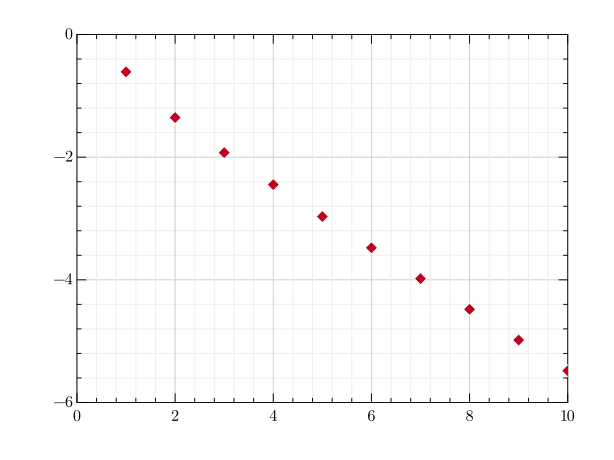

In [13]:
#plot
using GR
x = 1:1:10
xlim([0, 10])
ylim([-6, 0])
for i = 1:1:10
    y = real(e[i])
    println("r = $i ,energy = $y")
end
plot(x, real(e),"red")

### 温度 β

In [14]:
#full test change β
e = zeros(10) + im * zeros(10)
for i = 1:10
    M1, M2, ME1, ME2 = classicalisingmpo(0.1 * i; r = 2)
    D = 50
    Random.seed!(12345)
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    Random.seed!(12345)
    A2 = randn(D, 2, D) + im*randn(D, 2, D)
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
        vumps(A1,A2,M1,M2;tol = 1e-6,maxiter = 100)
    e[i] = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @show e[i]
end

Starting point has λL1 = 1.2070586119458757 ,λL2 =  1.2070586119459485
                    λR1 = 1.2070586119459026 ,λR2 =  1.20705861194589
Step 1: 
                                λ1 * λ2 = 4.140652118859893 + 9.769962616701378e-15im,
                                λL1 = 4.1435139538800385,
                                λL2 = 4.143513953879984, 
                                err1 ≈ 0.011955374948782307, 
                                err2 ≈ 0.011385229807105076
Step 2: 
                                    λ1 * λ2 = 4.143894286688228 - 4.884981308350689e-15im,
                                    λL1 = 4.14389428656611,
                                    λL2 = 4.143894286566122, 
                                    err1 ≈ 7.309061112478387e-7, 
                                    err2 ≈ 7.15563520148381e-7
e[i] = -0.2520964708080865 - 3.9824101048108185e-17im
Starting point has λL1 = 1.628711706739581 ,λL2 =  1.6287117067395744
                    λR1 = 1.6287117067395647 ,λR2 

Step 2: 
                                    λ1 * λ2 = 33.18586181570909 + 9.769962616701378e-15im,
                                    λL1 = 33.18586181663387,
                                    λL2 = 33.18586181663373, 
                                    err1 ≈ 1.3937324042024745e-6, 
                                    err2 ≈ 1.4455070944521012e-6
Step 3: 
                                    λ1 * λ2 = 33.18586181663964 + 5.329070518200751e-15im,
                                    λL1 = 33.18586181663948,
                                    λL2 = 33.1858618166398, 
                                    err1 ≈ 1.6483187390988516e-11, 
                                    err2 ≈ 1.2797271117436935e-11
e[i] = -1.4937441972299978 + 2.669678443156104e-16im
Starting point has λL1 = 19.47810815854553 ,λL2 =  19.478108158545492
                    λR1 = 19.478108158545478 ,λR2 =  19.478108158545318
Step 1: 
                                λ1 * λ2 = 54.629988005080975 + 1.0658141036401503e-14

β = 0.1 ,energy = -0.2520964708080865
β = 0.2 ,energy = -0.5118030602196689
β = 0.3 ,energy = -0.6758413842342361
β = 0.4 ,energy = -1.2434558611555113
β = 0.5 ,energy = -1.442210579628941
β = 0.6 ,energy = -1.481634788550331
β = 0.7 ,energy = -1.4937441972299978
β = 0.8 ,energy = -1.497802851579992
β = 0.9 ,energy = -1.4992133211590644
β = 1.0 ,energy = -1.4997180622908697


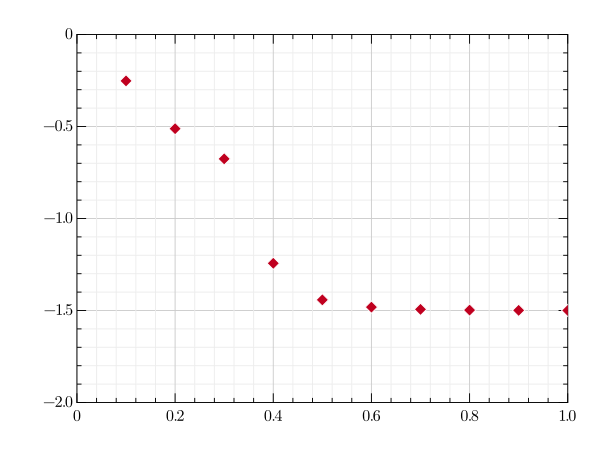

In [15]:
#plot
using GR
x = 0.1:0.1:1.0
xlim([0, 1.0])
ylim([-2, 0])
for i = 1:1:10
    β= i/10
    y = real(e[i])
    println("β = $β ,energy = $y")
end
plot(x, real(e),"red")

## <font color=Red>待解决问题</font> 
### 快速迭代得到$L1，L2$时不收敛
<img src="figure/18.png" width="100%">

### r = 1.01~1.1之间时能量不能极小化

In [16]:
# r = 1.01~1.1
βc = log(1+sqrt(2))/2
β = 0.95*βc
e = zeros(10) + im * zeros(10)
for i = 1:10
    M1, M2, ME1, ME2 = classicalisingmpo(β; r = 1.0 + 0.01 * i)
    D = 50
    Random.seed!(12345)
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    Random.seed!(12345)
    A2 = randn(D, 2, D) + im*randn(D, 2, D)
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
        vumps(A1,A2,M1,M2;tol = 1e-6,maxiter = 100)
    e[i] = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @show e[i]
end

Starting point has λL1 = 2.73775664832731 ,λL2 =  2.737756648327314
                    λR1 = 2.737756648327319 ,λR2 =  2.7377566483273257
Step 1: 
                                λ1 * λ2 = 6.0276938710479 + 1.887379141862766e-14im,
                                λL1 = 6.046495277969509,
                                λL2 = 6.0464952779694325, 
                                err1 ≈ 0.011123938092035244, 
                                err2 ≈ 0.01110061981723978
Step 2: 
                                    λ1 * λ2 = 6.073205071098843 + 8.215650382226158e-15im,
                                    λL1 = 6.074472162309875,
                                    λL2 = 6.074472162309863, 
                                    err1 ≈ 0.0016818459345238458, 
                                    err2 ≈ 0.0016565724759423674
Step 3: 
                                    λ1 * λ2 = 6.077104666529195 - 6.661338147750939e-16im,
                                    λL1 = 6.077190087158255,
              

                                    err2 ≈ 2.361907808764107e-6
Step 19: 
                                    λ1 * λ2 = 6.092908665908459 + 8.43769498715119e-15im,
                                    λL1 = 6.092908958188438,
                                    λL2 = 6.092908958188391, 
                                    err1 ≈ 1.68955389069559e-6, 
                                    err2 ≈ 1.8969559519239427e-6
Step 20: 
                                    λ1 * λ2 = 6.0929094226661 - 1.63202784619898e-14im,
                                    λL1 = 6.092907354899236,
                                    λL2 = 6.0929073548992205, 
                                    err1 ≈ 1.7791660775399647e-5, 
                                    err2 ≈ 1.7163284460449856e-5
Step 21: 
                                    λ1 * λ2 = 6.092909136913286 - 4.440892098500626e-15im,
                                    λL1 = 6.0929089611830545,
                                    λL2 = 6.092908961183077, 
    

                                    err2 ≈ 0.00197477952027006
Step 3: 
                                    λ1 * λ2 = 6.124360713139719 + 5.773159728050814e-15im,
                                    λL1 = 6.12476925933616,
                                    λL2 = 6.124769259336172, 
                                    err1 ≈ 0.0003007343029507068, 
                                    err2 ≈ 0.000345738657910447
Step 4: 
                                    λ1 * λ2 = 6.1248266529876565 - 1.9317880628477724e-14im,
                                    λL1 = 6.124842991578561,
                                    λL2 = 6.124842991578562, 
                                    err1 ≈ 1.912809860586504e-5, 
                                    err2 ≈ 2.074675548798868e-5
Step 5: 
                                    λ1 * λ2 = 6.124843039842991 + 1.4210854715202004e-14im,
                                    λL1 = 6.124843369325339,
                                    λL2 = 6.124843369325306, 
     

                                    err2 ≈ 2.638886149786735e-6
Step 26: 
                                    λ1 * λ2 = 6.124843782048979 - 3.9968028886505635e-15im,
                                    λL1 = 6.124844000869709,
                                    λL2 = 6.1248440008697465, 
                                    err1 ≈ 2.9173527477138968e-6, 
                                    err2 ≈ 5.65679082242938e-6
Step 27: 
                                    λ1 * λ2 = 6.124844222318424 + 3.552713678800501e-15im,
                                    λL1 = 6.124843936282618,
                                    λL2 = 6.1248439362826375, 
                                    err1 ≈ 3.431181152927357e-6, 
                                    err2 ≈ 1.3854255940105418e-5
Step 28: 
                                    λ1 * λ2 = 6.124844568000853 - 1.2878587085651816e-14im,
                                    λL1 = 6.124843963081202,
                                    λL2 = 6.124843963081169, 

Step 8: 
                                    λ1 * λ2 = 6.141077879804593 - 1.63202784619898e-14im,
                                    λL1 = 6.1410693197843775,
                                    λL2 = 6.141069319784386, 
                                    err1 ≈ 2.8613144634488893e-5, 
                                    err2 ≈ 5.1694705718028256e-5
Step 9: 
                                    λ1 * λ2 = 6.141069631983078 + 4.440892098500626e-16im,
                                    λL1 = 6.141072015150227,
                                    λL2 = 6.141072015150214, 
                                    err1 ≈ 1.1888403257405574e-5, 
                                    err2 ≈ 1.0045738842249884e-5
Step 10: 
                                    λ1 * λ2 = 6.141072287897748 - 2.4424906541753444e-15im,
                                    λL1 = 6.141074530091189,
                                    λL2 = 6.141074530091241, 
                                    err1 ≈ 2.79994836731453e-6, 


                                    err2 ≈ 6.966095387439466e-6
Step 16: 
                                    λ1 * λ2 = 6.157489820494275 + 5.440092820663267e-15im,
                                    λL1 = 6.157487640722421,
                                    λL2 = 6.157487640722419, 
                                    err1 ≈ 2.1782261155489275e-5, 
                                    err2 ≈ 1.5792052364246603e-5
Step 17: 
                                    λ1 * λ2 = 6.157489630159124 - 1.9095836023552692e-14im,
                                    λL1 = 6.157489466867489,
                                    λL2 = 6.1574894668674505, 
                                    err1 ≈ 4.577056583292463e-6, 
                                    err2 ≈ 1.126972045486441e-5
Step 18: 
                                    λ1 * λ2 = 6.1574895873249105 - 1.2434497875801753e-14im,
                                    λL1 = 6.157489461359944,
                                    λL2 = 6.157489461359956,

Step 7: 
                                    λ1 * λ2 = 6.174074336343129 - 8.881784197001252e-16im,
                                    λL1 = 6.174073460952696,
                                    λL2 = 6.174073460952727, 
                                    err1 ≈ 2.1349958674505616e-5, 
                                    err2 ≈ 6.773662529417973e-6
Step 8: 
                                    λ1 * λ2 = 6.174073852976063 + 5.773159728050814e-15im,
                                    λL1 = 6.174076637942064,
                                    λL2 = 6.174076637942051, 
                                    err1 ≈ 7.819579591241441e-6, 
                                    err2 ≈ 3.6894994327243094e-6
Step 9: 
                                    λ1 * λ2 = 6.174076646304641 + 2.1760371282653068e-14im,
                                    λL1 = 6.174077566473896,
                                    λL2 = 6.174077566473936, 
                                    err1 ≈ 5.446771346576775e-6, 
  

                                    err2 ≈ 7.439033760144779e-6
Step 31: 
                                    λ1 * λ2 = 6.174080349388183 - 1.7763568394002505e-15im,
                                    λL1 = 6.1740812309437585,
                                    λL2 = 6.174081230943851, 
                                    err1 ≈ 3.0207416966502462e-6, 
                                    err2 ≈ 2.106149389340273e-6
Step 32: 
                                    λ1 * λ2 = 6.174081239681925 + 4.440892098500626e-16im,
                                    λL1 = 6.174080339647228,
                                    λL2 = 6.174080339647221, 
                                    err1 ≈ 5.639422885888849e-6, 
                                    err2 ≈ 4.625280090010718e-6
Step 33: 
                                    λ1 * λ2 = 6.1740822270026765 + 4.440892098500626e-15im,
                                    λL1 = 6.1740813192031965,
                                    λL2 = 6.174081319203233, 

                                    err2 ≈ 1.842946414911522e-5
Step 7: 
                                    λ1 * λ2 = 6.19084166952813 - 1.1546319456101628e-14im,
                                    λL1 = 6.190847238470841,
                                    λL2 = 6.190847238470905, 
                                    err1 ≈ 1.1055644886938369e-5, 
                                    err2 ≈ 7.938735071071138e-6
Step 8: 
                                    λ1 * λ2 = 6.190872553003336 + 3.9968028886505635e-15im,
                                    λL1 = 6.19084319499383,
                                    λL2 = 6.190843194993846, 
                                    err1 ≈ 1.6790492955605447e-5, 
                                    err2 ≈ 3.2797127814301926e-5
Step 9: 
                                    λ1 * λ2 = 6.190870707404492 + 2.3314683517128287e-14im,
                                    λL1 = 6.190852275696324,
                                    λL2 = 6.190852275696388, 
   

Step 30: 
                                    λ1 * λ2 = 6.190880131980103 + 5.315192730392937e-15im,
                                    λL1 = 6.19085182624551,
                                    λL2 = 6.19085182624554, 
                                    err1 ≈ 4.666087045724971e-6, 
                                    err2 ≈ 7.095626819974109e-6
Step 31: 
                                    λ1 * λ2 = 6.190852037477561 + 4.6629367034256575e-14im,
                                    λL1 = 6.19085354577733,
                                    λL2 = 6.19085354577734, 
                                    err1 ≈ 4.3785349278610995e-6, 
                                    err2 ≈ 2.2407914236335185e-6
Step 32: 
                                    λ1 * λ2 = 6.190853703027282 + 2.220446049250313e-14im,
                                    λL1 = 6.190854182422505,
                                    λL2 = 6.1908541824224965, 
                                    err1 ≈ 3.8873463058609545e-6, 
 

                                    err2 ≈ 3.1988066054684305e-5
Step 54: 
                                    λ1 * λ2 = 6.1908488269573745 + 8.881784197001252e-16im,
                                    λL1 = 6.190841635961476,
                                    λL2 = 6.190841635961466, 
                                    err1 ≈ 1.9487375667596648e-5, 
                                    err2 ≈ 1.5987425150794417e-5
Step 55: 
                                    λ1 * λ2 = 6.190880402195861 + 1.8207657603852567e-14im,
                                    λL1 = 6.190851442184616,
                                    λL2 = 6.1908514421846625, 
                                    err1 ≈ 1.4044651170663695e-5, 
                                    err2 ≈ 6.150576565648686e-6
Step 56: 
                                    λ1 * λ2 = 6.1908586850186555 + 1.149080830487037e-14im,
                                    λL1 = 6.190853130102279,
                                    λL2 = 6.19085313010222

                                    err2 ≈ 4.280919335423975e-6
Step 12: 
                                    λ1 * λ2 = 6.207809785179437 - 1.3322676295501878e-15im,
                                    λL1 = 6.207809630459258,
                                    λL2 = 6.207809630459274, 
                                    err1 ≈ 7.62152240334685e-6, 
                                    err2 ≈ 5.943052347028655e-6
Step 13: 
                                    λ1 * λ2 = 6.207810043021572 + 8.881784197001252e-15im,
                                    λL1 = 6.207809424150105,
                                    λL2 = 6.207809424150107, 
                                    err1 ≈ 1.2452652734555556e-5, 
                                    err2 ≈ 1.3400585837949109e-5
Step 14: 
                                    λ1 * λ2 = 6.2078097239503345 - 7.438494264988549e-15im,
                                    λL1 = 6.207809613445321,
                                    λL2 = 6.2078096134453675, 


                                    err2 ≈ 7.511744272686934e-6
Step 35: 
                                    λ1 * λ2 = 6.207809789569751 - 5.329070518200751e-15im,
                                    λL1 = 6.207805646743654,
                                    λL2 = 6.20780564674365, 
                                    err1 ≈ 5.4157176389148035e-5, 
                                    err2 ≈ 6.40018200094877e-5
Step 36: 
                                    λ1 * λ2 = 6.207809548560624 + 0.0im,
                                    λL1 = 6.207809082837424,
                                    λL2 = 6.2078090828374615, 
                                    err1 ≈ 3.5488438838462836e-6, 
                                    err2 ≈ 3.117734898362467e-6
Step 37: 
                                    λ1 * λ2 = 6.207809446236223 + 7.993605777301127e-15im,
                                    λL1 = 6.207809531936064,
                                    λL2 = 6.207809531936024, 
                     

                                    err2 ≈ 4.145317315445691e-6
Step 58: 
                                    λ1 * λ2 = 6.207809602452985 + 5.995204332975845e-15im,
                                    λL1 = 6.207809600343204,
                                    λL2 = 6.2078096003432135, 
                                    err1 ≈ 7.7382858236141e-6, 
                                    err2 ≈ 7.892200698835392e-6
Step 59: 
                                    λ1 * λ2 = 6.207810116687883 - 2.7977620220553945e-14im,
                                    λL1 = 6.207809599140024,
                                    λL2 = 6.207809599139919, 
                                    err1 ≈ 5.257605756490438e-6, 
                                    err2 ≈ 6.571697606222244e-6
Step 60: 
                                    λ1 * λ2 = 6.207809640140512 - 2.6645352591003757e-15im,
                                    λL1 = 6.207809650790378,
                                    λL2 = 6.2078096507903515, 
  

                                    err2 ≈ 2.636743791220568e-6
Step 19: 
                                    λ1 * λ2 = 6.224947533840486 + 3.68594044175552e-14im,
                                    λL1 = 6.224946827696001,
                                    λL2 = 6.224946827696073, 
                                    err1 ≈ 2.009667399801114e-6, 
                                    err2 ≈ 5.340577055111883e-6
Step 20: 
                                    λ1 * λ2 = 6.224948621701563 - 2.602362769721367e-13im,
                                    λL1 = 6.2249485183301605,
                                    λL2 = 6.224948518330194, 
                                    err1 ≈ 2.579612676229327e-5, 
                                    err2 ≈ 1.8691133099849658e-5
Step 21: 
                                    λ1 * λ2 = 6.22494974758046 + 1.1879386363489175e-14im,
                                    λL1 = 6.2249482398462455,
                                    λL2 = 6.224948239846217, 
  

                                    err2 ≈ 2.1587146865090776e-5
Step 42: 
                                    λ1 * λ2 = 6.224949379973217 - 1.7763568394002505e-15im,
                                    λL1 = 6.224946166647779,
                                    λL2 = 6.224946166647713, 
                                    err1 ≈ 3.848275191742e-5, 
                                    err2 ≈ 3.596593768597174e-5
Step 43: 
                                    λ1 * λ2 = 6.224963045411684 + 7.105427357601002e-15im,
                                    λL1 = 6.224938106234908,
                                    λL2 = 6.22493810623496, 
                                    err1 ≈ 1.3758876220418895e-5, 
                                    err2 ≈ 1.377567584590387e-5
Step 44: 
                                    λ1 * λ2 = 6.224938906022387 + 7.993605777301127e-15im,
                                    λL1 = 6.224940036034323,
                                    λL2 = 6.224940036034376, 
     

                                    err2 ≈ 6.216147743664356e-6
Step 65: 
                                    λ1 * λ2 = 6.22494993261871 - 1.7069679003611782e-15im,
                                    λL1 = 6.224946981121164,
                                    λL2 = 6.224946981121156, 
                                    err1 ≈ 4.554557638333367e-6, 
                                    err2 ≈ 4.2243051317243746e-6
Step 66: 
                                    λ1 * λ2 = 6.2249513456796635 - 2.6423307986078726e-14im,
                                    λL1 = 6.224948040351199,
                                    λL2 = 6.224948040351239, 
                                    err1 ≈ 2.6086675795063516e-5, 
                                    err2 ≈ 1.7053821006313214e-5
Step 67: 
                                    λ1 * λ2 = 6.22494915783475 - 5.10702591327572e-14im,
                                    λL1 = 6.2249488180665375,
                                    λL2 = 6.224948818066564, 


                                    err2 ≈ 2.8076590512365074e-5
Step 88: 
                                    λ1 * λ2 = 6.224969205202086 - 7.993605777301127e-15im,
                                    λL1 = 6.224945312089135,
                                    λL2 = 6.22494531208918, 
                                    err1 ≈ 1.5675097681713936e-5, 
                                    err2 ≈ 5.5727868310871135e-6
Step 89: 
                                    λ1 * λ2 = 6.224954270263433 + 1.887379141862766e-15im,
                                    λL1 = 6.224948522154912,
                                    λL2 = 6.2249485221548415, 
                                    err1 ≈ 2.4437797266115202e-6, 
                                    err2 ≈ 1.3008405359052805e-6
Step 90: 
                                    λ1 * λ2 = 6.224950414138316 - 5.329070518200751e-15im,
                                    λL1 = 6.22494475986829,
                                    λL2 = 6.224944759868333, 


r = 1.01 ,energy = -0.6110874839067892
r = 1.02 ,energy = -0.43552284979923844
r = 1.03 ,energy = -0.44269122581356024
r = 1.04 ,energy = -0.4274098918491337
r = 1.05 ,energy = -0.4143696276134185
r = 1.06 ,energy = -0.42777438530009065
r = 1.07 ,energy = -0.42248578733833175
r = 1.08 ,energy = -0.441643739989568
r = 1.09 ,energy = -0.4427584270450737
r = 1.1 ,energy = -0.5361305199670348


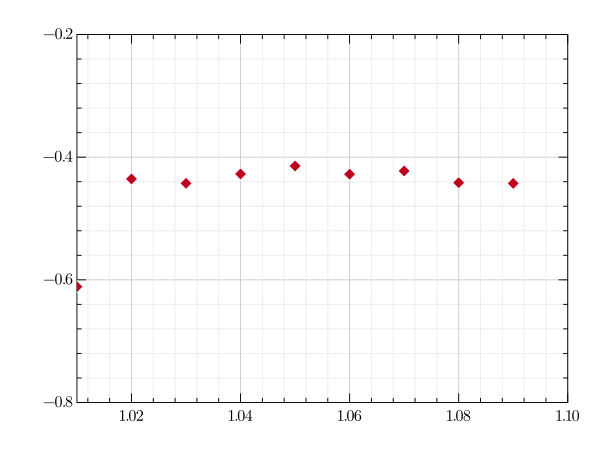

In [17]:
#plot
using GR
x = 1.01:0.01:1.1
xlim([1.01, 1.1])
ylim([-0.8, -0.2])
for i = 1:1:10
    r = 1.0 + 0.01 * i
    y = real(e[i])
    println("r = $r ,energy = $y")
end
plot(x, real(e),"red")